# **arxiv-evaluation**

Evaluating the quality of embeddings across increasingly specialized models.


## **Setup**

This notebook is designed to work in both Google Colab and local environments.

**For Google Colab:**
- **Mount Google Drive:** Enables saving files and accessing them across Colab.
    > ⚠ **Warning** <br>
    > This mounts your entire Google Drive, giving theoretical access to all files. While the code only accesses the project folder, consider using a dedicated Google account.
- **Clone the repository:** Ensures the latest code and utility modules are available.
- Add repo to Python path: Lets us import custom project modules as regular Python packages.

**For local environments:**
- Add project root to Python path: Lets us import custom project modules from the parent directory.

[ Optionally ]:
- Enable Autoreload: Lets us modify utility modules without having to reload them manually (useful for development).

In [ ]:
import os
import sys

from IPython import get_ipython


def setup_environment(repo_url, dev=False, drive_mount_path="/content/drive"):
    """Sets up the development environment for both Google Colab and local environments."""

    if "google.colab" not in sys.modules:
        # Define local project root
        project_root = os.path.dirname(os.getcwd())

        print("Not running in Google Colab.\nSkipping Colab setup.")

    else:
        # Mount Google Drive
        from google.colab import drive
        drive.mount(drive_mount_path, force_remount=True)

        # Define where within Drive to clone the git repository
        project_parent_dir = os.path.join(drive_mount_path, "MyDrive")
        project_name = repo_url.split("/")[-1].replace('.git', "")
        project_root = os.path.join(project_parent_dir, project_name)

        # Clone the repository if it doesn't exist
        if not os.path.exists(project_root):
            print(f"\nCloning repository into {project_root}")
            try:
                os.chdir(project_parent_dir)  # Change to the parent directory to clone the repo
                !git clone {repo_url}
            finally:
                os.chdir(project_root)  # Always change back to the original directory, even if clone fails
        else:
            print(f"\nRepository already exists at {project_root}")

        print("\nColab setup complete.")

    # Add project to Python path
    if project_root not in sys.path:
        sys.path.insert(0, project_root)
        print(f"\n'{project_root}' added to Python path.")
    else:
        print(f"\n'{project_root}' in Python path.")

    # Enable autoreload (for developement)
    if dev:
        ipython = get_ipython()

        # # Load extension quietly if not already loaded
        if "autoreload" not in ipython.extension_manager.loaded:
            ipython.magic("load_ext autoreload")

        print("\nAutoreload extension enabled (mode 2).")
        ipython.magic("autoreload 2")

In [ ]:
setup_environment("https://github.com/nadrajak/arxiv-recommender.git", dev=False)

## **Imports**

In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, silhouette_score
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE

import torch

from sentence_transformers import SentenceTransformer
from sentence_transformers.evaluation import TripletEvaluator
from sentence_transformers.evaluation import InformationRetrievalEvaluator


# Custom modules
from utils import config
from utils import data_loader
from utils import preprocessing
from utils import triplet_dataset

In [ ]:
# Initialize randomness
np.random.seed(config.RANDOM_SEED);
torch.manual_seed(config.RANDOM_SEED);

config.setup_plot_style()

## **Load data**


We use the [arXiv dataset from Kaggle](https://www.kaggle.com/Cornell-University/arxiv), which contains metadata and abstracts for scholarly papers across STEM fields.

Below, we load a sample of the dataset and briefly inspect its structure.

In [ ]:
# Download dataset from Kaggle
arxiv_dataset_path = data_loader.load_arxiv_dataset()

Using Colab cache for faster access to the 'arxiv' dataset.


In [ ]:
# Load json file as a pandas DataFrame
eval_nrows = 1_000
data = pd.read_json(arxiv_dataset_path, lines=True, nrows=(config.FT_NROWS + eval_nrows))

# Skip first `config.FT_NROWS` because they were used for training
data = data.iloc[config.FT_NROWS:]

print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 15000 to 15999
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              1000 non-null   float64
 1   submitter       1000 non-null   object 
 2   authors         1000 non-null   object 
 3   title           1000 non-null   object 
 4   comments        875 non-null    object 
 5   journal-ref     512 non-null    object 
 6   doi             646 non-null    object 
 7   report-no       80 non-null     object 
 8   categories      1000 non-null   object 
 9   license         77 non-null     object 
 10  abstract        1000 non-null   object 
 11  versions        1000 non-null   object 
 12  update_date     1000 non-null   object 
 13  authors_parsed  1000 non-null   object 
dtypes: float64(1), object(13)
memory usage: 109.5+ KB
None


## **Preprocessing**

In [ ]:
# Select essential columns
data = data[["title", "abstract", "categories", "authors"]].copy()

# Apply light preprocessing to text columns
data = preprocessing.normalize_whitespace(data)
data = preprocessing.normalize_abstracts(data)

# Simplify categories
data = preprocessing.truncate_categories(data)

In [ ]:
data.head()

,title,abstract,category,authors
15000,Nonlinear transport of Bose-Einstein condensat...,We study the coherent flow of interacting Bose...,cond-mat,"Tobias Paul, Michael Hartung, Klaus Richter, a..."
15001,On the geometry of the moduli space of spin cu...,We determine the smooth locus and the locus of...,math,Katharina Ludwig
15002,Rotational cooling efficiency upon molecular i...,The low-temperature (up to about 100K) collisi...,physics,"M. Wernli. E. Bodo, F.A. Gianturco"
15003,On the girth of random Cayley graphs,We prove that random d-regular Cayley graphs o...,math,"Alex Gamburd, Shlomo Hoory, Mehrdad Shahshahan..."
15004,A Conceptual Analysis of Mass Loss and Frequen...,To better understand Wolf-Rayet stars as proge...,astro-ph,A. J. Onifer and K. G. Gayley


## **Model evaluation**

We evaluate embeddings across a progression of increasingly specialized models to understand the impact of domain-specific pre-training on scientific text categorization:

- **GloVe**: Static word embeddings averaged to sentence level, representing pre-transformer approaches to text representation.<br>
[[Pennington et al., 2014](https://nlp.stanford.edu/pubs/glove.pdf)], [[Hugging Face](https://huggingface.co/sentence-transformers/average_word_embeddings_glove.6B.300d)].
- **BERT**: Transformer-based contextual embeddings trained on general English text, establishing the standard transformer baseline.<br>
[[Devlin et al., 2019](https://arxiv.org/abs/1810.04805)], [[Hugging Face](https://huggingface.co/bert-base-uncased)].
- **SciBERT**: BERT architecture retrained on scientific publications, isolating the effect of domain-specific pre-training.<br>
[[Beltagy et al., 2019](https://arxiv.org/abs/1903.10676)], [[Hugging Face](https://huggingface.co/allenai/scibert_scivocab_uncased)].
- **SPECTER**: SciBERT further trained on citation relationships to learn document-level semantic similarity in scientific literature.<br>
[[Cohan et al., 2020](https://arxiv.org/abs/2004.07180)], [[Hugging Face](https://huggingface.co/allenai/specter)].
- **SPECTER (fine-tuned)**: Our task-specific adaptation of SPECTER, optimized for the target classification task.

This progression allows us to measure the incremental benefit of domain adaptation (SciBERT vs BERT), document-level training (SPECTER vs SciBERT), and task-specific fine-tuning.

In [ ]:
model_configs = [
    ("average_word_embeddings_glove.6B.300d", "GloVe"),
    ("google-bert/bert-base-uncased", "BERT"),
    ("allenai/scibert_scivocab_uncased", "SciBERT"),
    ("allenai-specter", "SPECTER"),
    ("nadrajak/allenai-specter-ft2", "SPECTER (fine-tuned)"),
]

In [ ]:
# Load all models
model_names, model_pretty_names = zip(*model_configs)
models = [SentenceTransformer(name) for name in model_names]

### **Triplet accuracy**

First, we evaluate to what extent our fine-tuning enabled the model to correctly embed paper abstracts using **triplet accuracy**.

Triplet accuracy simply measures whether the embedding of a positive sample (same category) is closer to the anchor than the embedding of a negative sample (different category).

In [ ]:
anchors, positives, negatives = triplet_dataset.generate_triplets(data, n=len(data))

In [ ]:
evaluator = TripletEvaluator(
    anchors=anchors,
    positives=positives,
    negatives=negatives,
    similarity_fn_names=["cosine", "euclidean", "dot"],
)

In [ ]:
results = []
for model, model_name in zip(models, model_pretty_names):
    result = evaluator(model, output_path=None)
    result['model'] = model_name
    results.append(result)

results_df = pd.DataFrame(results).set_index('model').drop(columns=['max_accuracy'])

In [ ]:
results_df.round(4)

,cosine_accuracy,euclidean_accuracy,dot_accuracy
model,,,
GloVe,0.6383,0.6311,0.5699
BERT,0.7264,0.7047,0.6933
SciBERT,0.7492,0.7409,0.6497
SPECTER,0.7896,0.7845,0.7979
SPECTER (fine-tuned),0.9275,0.9295,0.9306


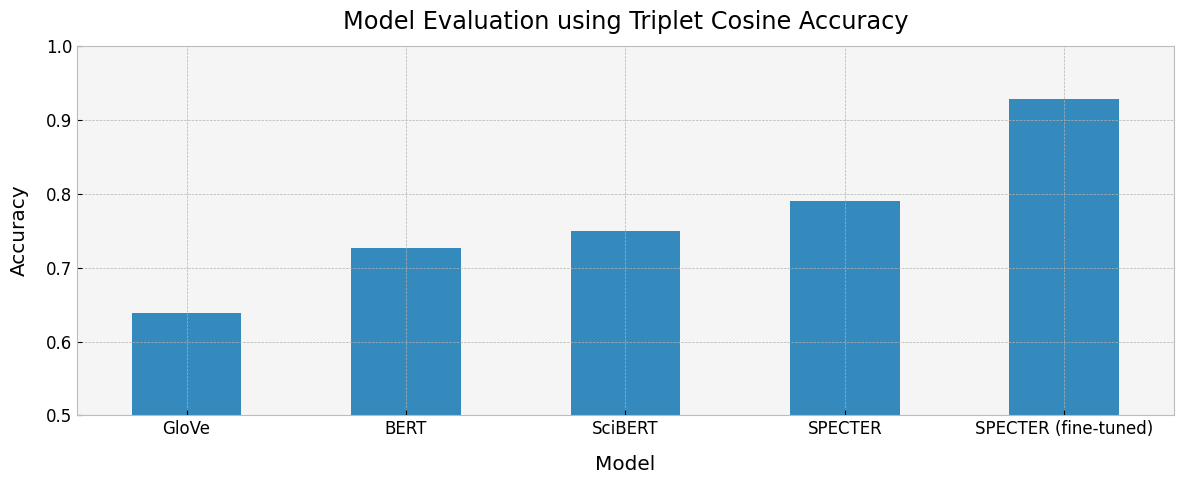

In [ ]:
results_df['cosine_accuracy'].plot(kind='bar', figsize=(12, 5))
plt.title('Model Evaluation using Triplet Cosine Accuracy')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.xticks(rotation=0, ha='center')
plt.ylim([0.5, 1])

plt.tight_layout()

**Analysis:**

The triplet accuracy results clearly show a progression in performance across the models, mirroring the increasing specialization.

The fine-tuned model demonstrates a significant jump in performance, achieving over 92% accuracy across all distance metrics. This improvement seems almost too substantial, but we consider it reasonable because the model was fine-tuned specifically using triplet loss based on arXiv categories, which is the exact task evaluated here.

This targeted fine-tuning has enabled the model to effectively learn the semantic relationships between abstracts within the context of arXiv categories, resulting in much better separation between related and unrelated papers in the embedding space compared to the base models.

The trend of increasing accuracy from GloVe to BERT, SciBERT, and SPECTER highlights the benefits of general domain pre-training (BERT), followed by scientific domain adaptation (SciBERT), and further training on citation graphs (SPECTER) for capturing semantic relationships in scientific text. The fine-tuned model then builds upon SPECTER's foundation with task-specific learning, achieving the highest performance on this triplet classification task.

### **Metrics@k**

To evaluate the models' ability to capture semantic relationships relevant to retrieval, we will use the `SentenceTransformers` `InformationRetrievalEvaluator`. This evaluator measures how well a model can retrieve relevant documents from a corpus given a query.

For this evaluation, each abstract in our dataset will serve as a query. The corpus will consist of all abstracts in the dataset. Relevance is defined by category: for a given query abstract, all other abstracts in the same category are considered relevant.

In [ ]:
# Split the dataset into query and corpus (It wont evaluate correctly if they are the same)
query_data, corpus_data = train_test_split(data, test_size=0.5, random_state=config.RANDOM_SEED)

In [ ]:
# Create a query and corpus dictionaries
queries = dict(zip(query_data.index.astype(str), query_data["abstract"]))
corpus = dict(zip(corpus_data.index.astype(str), corpus_data["abstract"]))

# Create a relevant document dictionary
relevant_docs = {}
for cat in data["category"]:
    # Get relevant docs for a given category
    relevant_ids = corpus_data[corpus_data["category"] == cat].index.astype(str)

    # Map relevant docs to each query
    query_ids = query_data[query_data["category"] == cat].index.astype(str)
    for query_id in query_ids:
        relevant_docs[query_id] = list(relevant_ids).copy()

In [ ]:
# Define top-k values
top_k = [1, 3, 5, 10, 25, 50]

# Create information retrieval evaluator
ir_evaluator = InformationRetrievalEvaluator(
    queries=queries,
    corpus=corpus,
    relevant_docs=relevant_docs,
    # corpus_chunk_size=500,
    accuracy_at_k=top_k,
    precision_recall_at_k=top_k,
    map_at_k=top_k,
    mrr_at_k=top_k,
    ndcg_at_k=top_k,
)

In [ ]:
# Evaluate each model
retrieval_results = []
for model, model_name in zip(models, model_pretty_names):
    print(f"Evaluating {model_name}...")
    result = ir_evaluator(model, output_path=None)
    result['model'] = model_name
    retrieval_results.append(result)

retrieval_results_df = pd.DataFrame(retrieval_results).set_index('model')

Evaluating GloVe...
Evaluating BERT...
Evaluating SciBERT...
Evaluating SPECTER...
Evaluating SPECTER (fine-tuned)...


In [ ]:
# Remove the 'cosine_' prefix
retrieval_results_df.columns = retrieval_results_df.columns.str.replace('cosine_', '')

# Create dictionaries to hold DataFrames for each metric type
precision_df = retrieval_results_df.filter(like='precision@').copy()
recall_df = retrieval_results_df.filter(like='recall@').copy()
accuracy_df = retrieval_results_df.filter(like='accuracy@').copy()
mrr_df = retrieval_results_df.filter(like='mrr@').copy()
map_df = retrieval_results_df.filter(like='map@').copy()
ndcg_df = retrieval_results_df.filter(like='ndcg@').copy()

In [ ]:
display(precision_df.round(4))
display(mrr_df.round(4))
display(ndcg_df.round(4))

,precision@1,precision@3,precision@5,precision@10,precision@25,precision@50
model,,,,,,
GloVe,0.5954,0.5402,0.5191,0.4878,0.4287,0.3787
BERT,0.6289,0.6045,0.5866,0.5566,0.5056,0.4632
SciBERT,0.7317,0.6995,0.6763,0.6453,0.5936,0.5384
SPECTER,0.7568,0.7296,0.7136,0.6732,0.6309,0.5768
SPECTER (fine-tuned),0.8134,0.7939,0.7866,0.7868,0.7644,0.7377


,mrr@1,mrr@3,mrr@5,mrr@10,mrr@25,mrr@50
model,,,,,,
GloVe,0.5954,0.6712,0.6844,0.6944,0.6990,0.6994
BERT,0.6289,0.6985,0.7128,0.7227,0.7260,0.7267
SciBERT,0.7317,0.7858,0.7943,0.8003,0.8033,0.8039
SPECTER,0.7568,0.8068,0.8150,0.8191,0.8218,0.8223
SPECTER (fine-tuned),0.8134,0.8484,0.8541,0.8569,0.8586,0.8589


,ndcg@1,ndcg@3,ndcg@5,ndcg@10,ndcg@25,ndcg@50
model,,,,,,
GloVe,0.5954,0.5525,0.5347,0.5082,0.4632,0.4317
BERT,0.6289,0.6097,0.5961,0.5732,0.5394,0.5190
SciBERT,0.7317,0.7063,0.6887,0.6640,0.6306,0.6047
SPECTER,0.7568,0.7361,0.7238,0.6940,0.6690,0.6481
SPECTER (fine-tuned),0.8134,0.7977,0.7920,0.7932,0.7960,0.8097


In [ ]:
# Select precision, mrr, and ndcg at k=10
metrics_at_10 = retrieval_results_df[['precision@10', 'mrr@10', 'ndcg@10']]
display(metrics_at_10.round(4))

,precision@10,mrr@10,ndcg@10
model,,,
GloVe,0.4878,0.6944,0.5082
BERT,0.5566,0.7227,0.5732
SciBERT,0.6453,0.8003,0.6640
SPECTER,0.6732,0.8191,0.6940
SPECTER (fine-tuned),0.7868,0.8569,0.7932


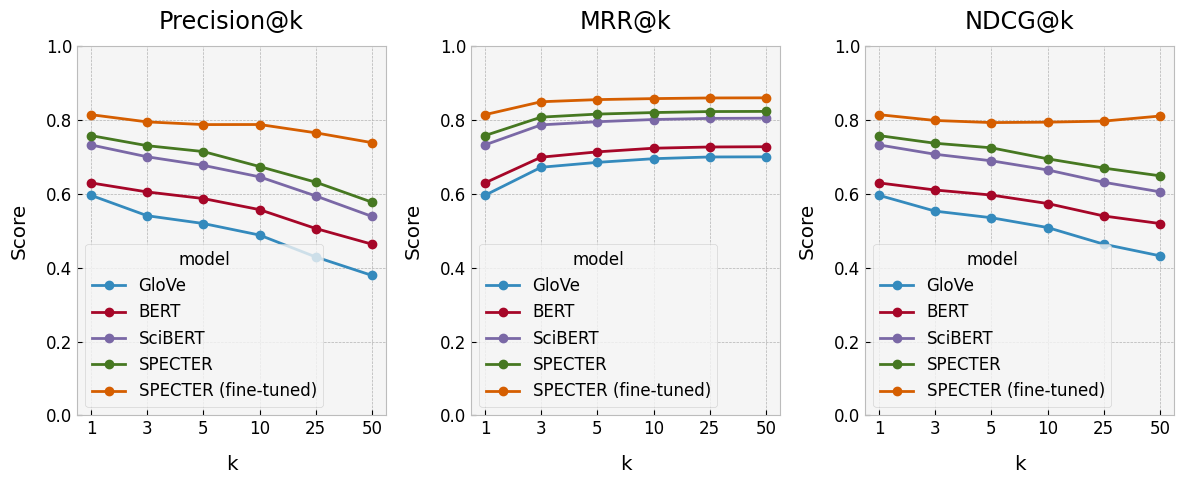

In [ ]:
# Plotting each metric across different k values
fig, axes = plt.subplots(1, 3, figsize=(12, 5), sharey=False)

# Precision plot
precision_df.T.plot(ax=axes[0], marker='o')
axes[0].set_title('Precision@k')

# MRR plot
mrr_df.T.plot(ax=axes[1], marker='o')
axes[1].set_title('MRR@k')

# NDCG plot
ndcg_df.T.plot(ax=axes[2], marker='o')
axes[2].set_title('NDCG@k')

# Shared settings
for ax in axes:
    ax.set_xlabel('k')
    ax.set_ylabel('Score')
    ax.set_xticks(range(len(top_k)))
    ax.set_xticklabels(top_k)
    ax.set_ylim(0, 1)
plt.tight_layout()
plt.show()

**Analysis**:

...


### **Clustering**


Next, we evaluate how well embedding separation in the feature space aligns with true categories using multiple clustering metrics:

- **Adjusted Rand Index (ARI):** Similarity between the true categories and the predicted clusters, adjusted for chance.
- **Normalized Mutual Information (NMI):** Mutual dependence between the true categories and the predicted clusters.
- **Silhouette Coefficient:** Average similarity of an object to its own cluster compared to other clusters.

We use Kmeans as our clustering algorithm, with k equal to the number of categories.





In [ ]:
def evaluate_clustering(embeddings, true_categories, n_clusters=None):
    if n_clusters is None:
        n_clusters = len(set(true_categories))

    # Cluster embeddings
    kmeans = KMeans(n_clusters=n_clusters, random_state=config.RANDOM_SEED)
    predicted_clusters = kmeans.fit_predict(embeddings)

    # Calculate metrics
    ari = adjusted_rand_score(true_categories, predicted_clusters)
    nmi = normalized_mutual_info_score(true_categories, predicted_clusters)
    silhouette = silhouette_score(embeddings, predicted_clusters)

    return {'adjusted_rand_index': ari, 'normalized_mutual_info': nmi, 'silhouette_coeff': silhouette}

In [ ]:
abstracts = data["abstract"].to_list()
categories = data["category"].to_list()

In [ ]:
# Pre-calcuate embeddings
model_embeddings = [model.encode(abstracts) for model in models]

In [ ]:
# Evaluate using clustering metrics
clustering_results = []
for model_name, model_embedding in zip(model_pretty_names, model_embeddings):
    clustering_result = evaluate_clustering(model_embedding, categories)
    clustering_result['model'] = model_name
    clustering_results.append(clustering_result)

clustering_results_df = pd.DataFrame(clustering_results).set_index('model')

In [ ]:
clustering_results_df.round(4)

,adjusted_rand_index,normalized_mutual_info,silhouette_coeff
model,,,
GloVe,0.1660,0.3034,0.0214
BERT,0.1931,0.3671,0.0544
SciBERT,0.3011,0.4615,0.0509
SPECTER,0.4400,0.5271,0.1041
SPECTER (fine-tuned),0.6859,0.6794,0.3139


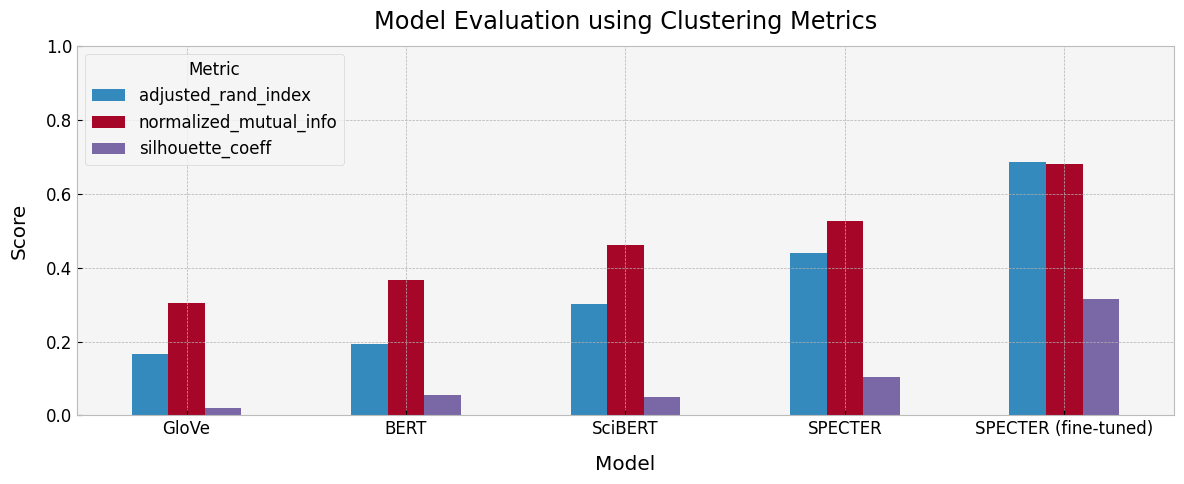

In [ ]:
clustering_results_df.plot(kind='bar', figsize=(12, 5))
plt.title('Model Evaluation using Clustering Metrics')
plt.xlabel('Model')
plt.ylabel('Score')
plt.ylim([0, 1])
plt.xticks(rotation=0, ha='center')
plt.legend(title='Metric', bbox_to_anchor=(0, 1), loc='upper left')

plt.tight_layout();

**Analysis:**

The overall trend mirrors that observed in the triplet evaluation: more specialized models better capture information in texts.

The fine-tuned model breaks two patterns in the results. First, ARI exceeds NMI, and second, the Silhouette coefficient doubles compared to the base SPECTER model.

From our exploration, we know the categories are unbalanced. We also know that we deliberately fine-tuned the model on the same unbalanced data to reflect the real-world data distribution.

The average Silhouette coefficient is a strict measure of how well-defined individual clusters are. The sharp increase could indicate that fine-tuning enabled the model to separate the majority categories with much greater precision.

The ARI > NMI also points to the same underlying cause. The true categories are unbalanced, and ARI is a pair-counting metric that considers pairs of data points and whether they are grouped together. The results suggest that this model is disproportionately better than others at grouping correct pairs, which could be caused by specializing in separating the majority categories.

This supports the conclusion that fine-tuning successfully increased the model's ability to distinguish between categories, specifically the majority ones.

In [ ]:
def reduce_dimensionality(embeddings, n_components=2):
    # TSNE(n_components=2, learning_rate='auto', init='random', perplexity=3)
    tsne = TSNE(n_components=n_components, init='random', random_state=config.RANDOM_SEED)
    return tsne.fit_transform(embeddings)

In [ ]:
# Reduce dimensionality of embeddings for visualization
model_2d_embeddings = [reduce_dimensionality(model_embedding) for model_embedding in model_embeddings]

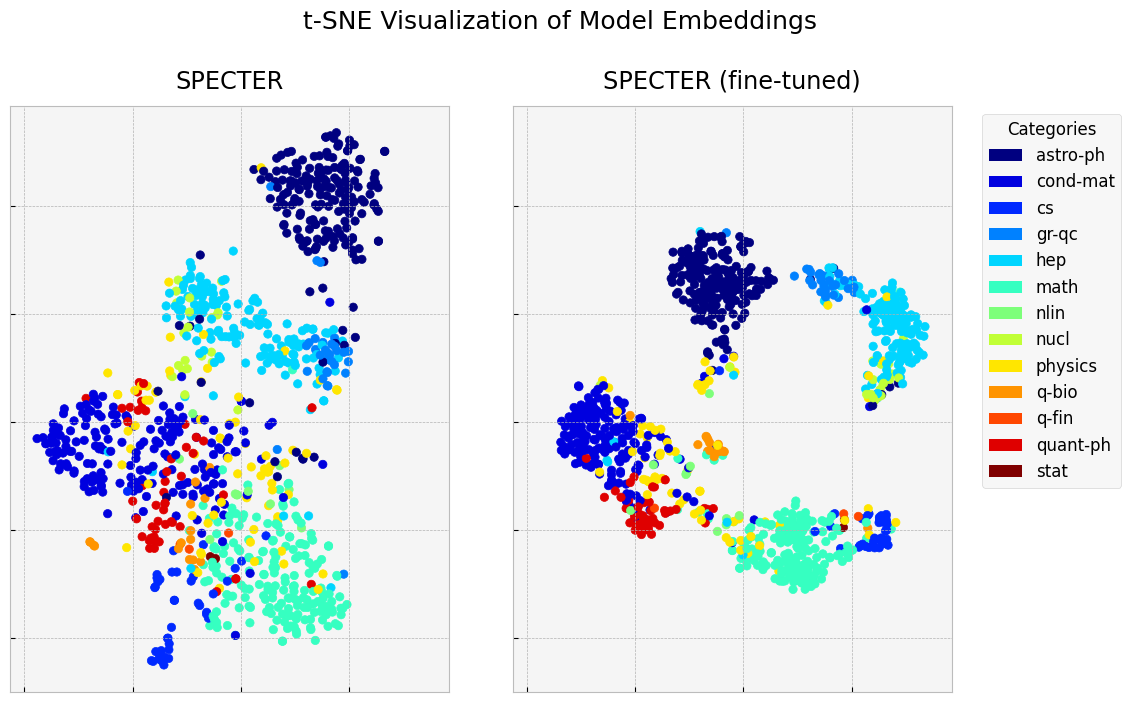

In [ ]:
# Select the models for visualization
models_to_plot_indices = [-2, -1]

embeddings_to_plot = [model_2d_embeddings[i] for i in models_to_plot_indices]
names_to_plot = [model_pretty_names[i] for i in models_to_plot_indices]

# Determine global min/max for consistent scaling with padding
padding = 5
all_embeddings_to_plot = np.vstack(embeddings_to_plot)
x_min, x_max = all_embeddings_to_plot[:, 0].min() - padding, all_embeddings_to_plot[:, 0].max() + padding
y_min, y_max = all_embeddings_to_plot[:, 1].min() - padding, all_embeddings_to_plot[:, 1].max() + padding

fig, axes = plt.subplots(1, len(embeddings_to_plot), figsize=(6 * len(embeddings_to_plot), 7))

# Ensure axes is an array even if there's only one subplot
if len(embeddings_to_plot) == 1:
    axes = [axes]

# Convert categories to pandas categorical for automatic numerical encoding
cat_series = pd.Categorical(categories)

for i, embeddings_2d in enumerate(embeddings_to_plot):
    ax = axes[i]

    # Plot using the 'jet' colormap based on numerical categories
    scatter = ax.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=cat_series.codes, cmap='jet')
    ax.set_title(f"{names_to_plot[i]}")

    # Set the aspect ratio to 'equal' and apply consistent scaling
    ax.set_aspect('equal', adjustable='box')
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)

    # Remove tick labels since t-SNE coordinates are not interpretable
    ax.set_xticklabels([])
    ax.set_yticklabels([])

    # Create a legend for the categories on the last plot
    if i == len(embeddings_to_plot) - 1:
        legend_elements = [Patch(facecolor=scatter.cmap(scatter.norm(code)), label=category)
                           for category, code in zip(cat_series.categories, range(len(cat_series.categories)))]
        ax.legend(handles=legend_elements, title="Categories", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.suptitle('t-SNE Visualization of Model Embeddings', y=1)
plt.tight_layout()

**Analysis:**

The t-SNE visualizations of the embeddings provide a visual confirmation of the clustering improvements observed in the metrics.

The plots show that the fine-tuned SPECTER model creates more distinct and well-separated clusters compared to the base SPECTER model, particularly for the four major categories present in the dataset.

## **Conclusion**

Our evaluation across a progression of increasingly specialized models reveals a clear trend: models with domain-specific pre-training and task-specific fine-tuning demonstrate superior performance in capturing the semantic relationships within our arXiv paper dataset.

**Triplet accuracy** improved as we moved from general models (GloVe, BERT) to scientific ones (SciBERT, SPECTER) to our fine-tuned version. The fine-tuned SPECTER model got over 92% accuracy, showing that training it specifically on arXiv categories worked well.

**Retrieval metrics**


...


**Clustering** results backed this up. The fine-tuned model created much cleaner clusters, especially for the major paper categories. The t-SNE plots showed this visually, the clusters were more separated and distinct.


This evaluation demonstrates the significant benefits of domain adaptation and task-specific fine-tuning. The fine-tuned SPECTER model, specifically trained on arXiv data using triplet loss, significantly outperforms the base and more general models on tasks related to categorizing scientific papers based on their abstracts.